In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [ ]:
# Set up data folder
DATA = Path('/content/drive/My Drive/data')

## MDM2 inhibitor and MDM2/TP53 mutations

Select only the drug data which has good sigmoid fit.

In [ ]:
pharm = pd.read_csv(DATA / "CCLE_NP24.2009_Drug_data_2015.02.24.csv")
pharm.head()

,CCLE Cell Line Name,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),IC50 (uM),Amax,ActArea
0,1321N1_CENTRAL_NERVOUS_SYSTEM,1321N1,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","8.67,11.0,2.16,.27,-10,-13,-26,-43","3.31,3.72,5.36,4.67,13.1,.18,2.42,7.51",8,Sigmoid,8.717774,8.000000,-42.558014,0.7124
1,22RV1_PROSTATE,22Rv1,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8",".94,12.5,-14,4.16,-25,-32,-52,-71","1.95,13.3,6.98,21.8,16.0,18.8,4.84,7.93",8,Sigmoid,8.165164,2.329924,-71.589340,1.6723
2,42MGBA_CENTRAL_NERVOUS_SYSTEM,42-MG-BA,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","8.91,8.39,-3.5,12.4,-.55,-6.2,-48,-63","13.7,7.70,11.1,6.43,24.0,9.57,9.57,10.4",8,Sigmoid,1.514508,2.682130,-63.491371,1.1852
3,5637_URINARY_TRACT,5637,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","2.15,9.91,-3.5,.056,-2.1,-14,-30,-62","4.05,9.75,12.7,4.36,11.0,10.0,24.6,.14",8,Sigmoid,8.006595,5.002314,-62.352776,0.9948
4,639V_URINARY_TRACT,639-V,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","11.8,-7.3,-9.4,-15,-11,-21,-53,-50",".95,5.67,11.1,.68,31.6,22.3,1.45,3.08",8,Sigmoid,0.931196,1.736181,-51.959808,1.5436


In [ ]:
# pharm.shape

In [ ]:
pharm_mdm2 = pharm.loc[(pharm.Target == 'MDM2') & (pharm.FitType == 'Sigmoid')].copy()
pharm_mdm2

,CCLE Cell Line Name,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),IC50 (uM),Amax,ActArea
2434,22RV1_PROSTATE,22Rv1,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-9.7,-11,-9.0,10.4,-2.3,-2.2,.26,-38","8.68,10.8,18.5,11.8,9.38,17.4,13.9,3.25",8,Sigmoid,7.660393,8.000000,-38.178085,0.7904
2438,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,697,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","2.75,-13,-15,13.2,-17,-13,-71,-94","25.9,9.18,6.04,6.06,22.5,5.67,2.98,.91",8,Sigmoid,1.931175,1.890524,-93.854889,2.7720
2439,769P_KIDNEY,769-P,Nutlin-3,MDM2,".0025,.025,.080,.25,.80,2.53,8","-1.9,.18,-5.3,3.90,6.93,-11,-53",".15,6.89,.98,9.63,8.11,24.5,3.05",7,Sigmoid,3.253213,5.591302,-52.759350,0.7115
2443,8MGBA_CENTRAL_NERVOUS_SYSTEM,8-MG-BA,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-27,-5.8,-.11,-2.7,14.1,21.1,-21,-31","30.8,.84,14.6,15.5,9.62,8.70,.81,5.67",8,Sigmoid,2.164914,8.000000,-31.357655,0.8426
2444,A172_CENTRAL_NERVOUS_SYSTEM,A172,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-1.7,-6.0,1.23,-2.8,-3.8,-5.6,-11,-28","3.06,6.86,8.66,2.42,8.39,14.8,13.4,9.02",8,Sigmoid,8.390720,8.000000,-28.074141,0.2102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,U87MG_CENTRAL_NERVOUS_SYSTEM,U-87 MG,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","8.06,10.8,-5.1,-.98,-1.1,.56,-12,-17","4.59,3.27,2.59,11.2,8.00,2.51,5.63,10.8",8,Sigmoid,8.298537,8.000000,-15.922485,0.4944
2929,WM1799_SKIN,WM1799,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-1.1,-5.6,-11,-1.5,-9.0,-7.9,-24,-37","3.36,11.3,1.43,.78,8.32,9.31,18.0,3.54",8,Sigmoid,2.341730,8.000000,-37.259308,1.0335
2930,WM2664_SKIN,WM-266-4,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-2.6,-1.1,-5.6,-5.2,-6.6,14.5,-21,-27","6.90,2.13,19.0,3.41,.24,.71,6.95,9.52",8,Sigmoid,2.103210,8.000000,-27.421812,0.7351
2931,WM793_SKIN,WM-793,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-19,-18,2.65,2.41,-2.9,-1.5,13.6,-29","8.26,5.75,10.2,9.13,18.6,15.6,9.32,11.9",8,Sigmoid,7.604923,8.000000,-28.789083,0.8620


In [ ]:
# name of the compound targeting MDM2
pharm_mdm2.Compound.unique()

array(['Nutlin-3'], dtype=object)

In [ ]:
# How many cell lines have sigmoid-fitted data for that particular drug targeting MDM2?
len(pharm_mdm2['CCLE Cell Line Name'].unique())

100

---

The correlation between the MDM2-targeting compound activity and MDM2 mutation. Exclude mutations with `Variant_Classification`: `Silent`, `5'Flank`, `Intron`, `IGR`, `3'UTR`, `5'UTR`

In [ ]:
maf = pd.read_csv(DATA / 'CCLE_DepMap_18q3_maf_20180718.txt', sep="\t", low_memory=False)
maf.head()

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,dbSNP_RS,dbSNP_Val_Status,Genome_Change,Annotation_Transcript,Tumor_Sample_Barcode,cDNA_Change,Codon_Change,Protein_Change,isDeleterious,isTCGAhotspot,TCGAhsCnt,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Broad_ID
0,DVL1,1855,37,1,1277461,1277461,+,Silent,SNP,C,T,NaN,NaN,g.chr1:1277461C>T,ENST00000378888.5,127399_SOFT_TISSUE,c.438G>A,c.(436-438)gaG>gaA,p.E146E,False,False,0,False,0,NaN,87:39,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270
1,AL590822.1,0,37,1,2144416,2144416,+,Missense_Mutation,SNP,G,A,NaN,NaN,g.chr1:2144416G>A,ENST00000545087.1,127399_SOFT_TISSUE,c.604C>T,c.(604-606)Cgc>Tgc,p.R202C,False,False,0,False,0,NaN,23:43,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270
2,PLCH2,9651,37,1,2435359,2435359,+,Splice_Site,SNP,A,C,NaN,NaN,g.chr1:2435359A>C,ENST00000419816.2,127399_SOFT_TISSUE,NaN,c.e22-1,NaN,True,False,0,False,0,NaN,9:25,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270
3,UBE4B,10277,37,1,10177641,10177641,+,Missense_Mutation,SNP,G,A,NaN,NaN,g.chr1:10177641G>A,ENST00000253251.8,127399_SOFT_TISSUE,c.934G>A,c.(934-936)Gaa>Aaa,p.E312K,False,False,0,False,0,NaN,13:95,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270
4,SRM,6723,37,1,11119363,11119363,+,Silent,SNP,G,T,rs34097618,NaN,g.chr1:11119363G>T,ENST00000376957.2,127399_SOFT_TISSUE,c.207C>A,c.(205-207)atC>atA,p.I69I,False,False,0,False,0,NaN,113:57,NaN,NaN,NaN,NaN,NaN,NaN,ACH-001270


In [ ]:
mdm2 = maf[(maf.Hugo_Symbol == "MDM2") & ~(maf.Variant_Classification.isin(
    ["Silent", "5'Flank", "Intron", "IGR", "3'UTR", "5'UTR"]))] 
# mdm2.head()

In [ ]:
mdm2_mut_samples = mdm2.Tumor_Sample_Barcode.unique()
mdm2_mut_samples

array(['SAOS2_BONE', 'SKNEP1_BONE', 'HEC251_ENDOMETRIUM',
       'SNUC4_LARGE_INTESTINE', '786O_KIDNEY', 'AGS_STOMACH',
       'NCIH1666_LUNG', 'NCIH2122_LUNG', 'COV644_OVARY',
       'HT115_LARGE_INTESTINE', 'SNU182_LIVER', 'CW2_LARGE_INTESTINE',
       'DSH1_URINARY_TRACT', 'ML2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
       'MOLT13_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
       'REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'SJSA1_BONE',
       'SNU1040_LARGE_INTESTINE', 'SNU81_LARGE_INTESTINE',
       'SNUC5_LARGE_INTESTINE', 'NCIBL2122_MATCHED_NORMAL_TISSUE',
       'RERFLCAD1_LUNG', 'U178_CENTRAL_NERVOUS_SYSTEM', 'EFO27_OVARY',
       'HCC1569_BREAST', 'LS411N_LARGE_INTESTINE', 'MFE296_ENDOMETRIUM',
       'MHHPREB1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'HCC1187_BREAST'],
      dtype=object)

In [ ]:
# How many unique cell lines in the MAF file have MDM2 mutations that are NOT 
# of Variant_Classfication Silent, 5'Flank, Intron, IGR, 3'UTR, 5'UTR?
len(mdm2_mut_samples)

29

In [ ]:
pharm_mdm2["mdm2_mut"] = False # indicating MDM2 mutation status
pharm_mdm2.loc[pharm_mdm2["CCLE Cell Line Name"].isin(mdm2_mut_samples), "mdm2_mut"] = True
pharm_mdm2

,CCLE Cell Line Name,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),IC50 (uM),Amax,ActArea,mdm2_mut
2434,22RV1_PROSTATE,22Rv1,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-9.7,-11,-9.0,10.4,-2.3,-2.2,.26,-38","8.68,10.8,18.5,11.8,9.38,17.4,13.9,3.25",8,Sigmoid,7.660393,8.000000,-38.178085,0.7904,False
2438,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,697,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","2.75,-13,-15,13.2,-17,-13,-71,-94","25.9,9.18,6.04,6.06,22.5,5.67,2.98,.91",8,Sigmoid,1.931175,1.890524,-93.854889,2.7720,False
2439,769P_KIDNEY,769-P,Nutlin-3,MDM2,".0025,.025,.080,.25,.80,2.53,8","-1.9,.18,-5.3,3.90,6.93,-11,-53",".15,6.89,.98,9.63,8.11,24.5,3.05",7,Sigmoid,3.253213,5.591302,-52.759350,0.7115,False
2443,8MGBA_CENTRAL_NERVOUS_SYSTEM,8-MG-BA,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-27,-5.8,-.11,-2.7,14.1,21.1,-21,-31","30.8,.84,14.6,15.5,9.62,8.70,.81,5.67",8,Sigmoid,2.164914,8.000000,-31.357655,0.8426,False
2444,A172_CENTRAL_NERVOUS_SYSTEM,A172,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-1.7,-6.0,1.23,-2.8,-3.8,-5.6,-11,-28","3.06,6.86,8.66,2.42,8.39,14.8,13.4,9.02",8,Sigmoid,8.390720,8.000000,-28.074141,0.2102,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,U87MG_CENTRAL_NERVOUS_SYSTEM,U-87 MG,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","8.06,10.8,-5.1,-.98,-1.1,.56,-12,-17","4.59,3.27,2.59,11.2,8.00,2.51,5.63,10.8",8,Sigmoid,8.298537,8.000000,-15.922485,0.4944,False
2929,WM1799_SKIN,WM1799,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-1.1,-5.6,-11,-1.5,-9.0,-7.9,-24,-37","3.36,11.3,1.43,.78,8.32,9.31,18.0,3.54",8,Sigmoid,2.341730,8.000000,-37.259308,1.0335,False
2930,WM2664_SKIN,WM-266-4,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-2.6,-1.1,-5.6,-5.2,-6.6,14.5,-21,-27","6.90,2.13,19.0,3.41,.24,.71,6.95,9.52",8,Sigmoid,2.103210,8.000000,-27.421812,0.7351,False
2931,WM793_SKIN,WM-793,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-19,-18,2.65,2.41,-2.9,-1.5,13.6,-29","8.26,5.75,10.2,9.13,18.6,15.6,9.32,11.9",8,Sigmoid,7.604923,8.000000,-28.789083,0.8620,False


In [ ]:
# how many unique cell lines in the MAF file with MDM2 mutations also have MDM2-targeting compound sensitivity profiling?
sum(pharm_mdm2.mdm2_mut)

2

Plot the IC50 corresponding to whether the cell lines containing MDM2 mutation or not.

In [ ]:
mwu, pval = mannwhitneyu(pharm_mdm2.loc[pharm_mdm2.mdm2_mut, "IC50 (uM)"],
                         pharm_mdm2.loc[~pharm_mdm2.mdm2_mut, "IC50 (uM)"],
                         alternative="two-sided")

Text(0.2, 4, 'M-W U = 41.0 (P-value = 0.0713)')

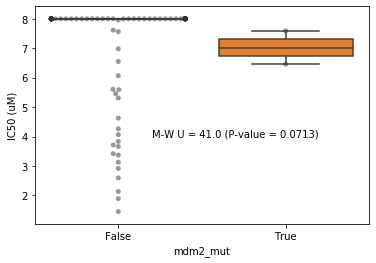

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(x="mdm2_mut", y="IC50 (uM)", data=pharm_mdm2, fliersize=0)
sns.swarmplot(x="mdm2_mut", y="IC50 (uM)", data=pharm_mdm2, color=".2", alpha=0.5)
ax.text(0.2, 4, "M-W U = {} (P-value = {})".format(mwu, np.round(pval, 4)))

The MDM2 mutation rate is very low in these cell lines with drug sensitivity data.

In [ ]:
# Consider the TP53 mutation instead of MDM2
tp53 = maf[(maf.Hugo_Symbol == "TP53") & ~(maf.Variant_Classification.isin(
    ["Silent", "5'Flank", "Intron", "IGR", "3'UTR", "5'UTR"]))] 

tp53_mut_samples = tp53.Tumor_Sample_Barcode.unique()

In [ ]:
pharm_mdm2["tp53_mut"] = False # indicating TP53 mutation status
pharm_mdm2.loc[pharm_mdm2["CCLE Cell Line Name"].isin(tp53_mut_samples), "tp53_mut"] = True
pharm_mdm2

,CCLE Cell Line Name,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),IC50 (uM),Amax,ActArea,mdm2_mut,tp53_mut
2434,22RV1_PROSTATE,22Rv1,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-9.7,-11,-9.0,10.4,-2.3,-2.2,.26,-38","8.68,10.8,18.5,11.8,9.38,17.4,13.9,3.25",8,Sigmoid,7.660393,8.000000,-38.178085,0.7904,False,True
2438,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,697,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","2.75,-13,-15,13.2,-17,-13,-71,-94","25.9,9.18,6.04,6.06,22.5,5.67,2.98,.91",8,Sigmoid,1.931175,1.890524,-93.854889,2.7720,False,False
2439,769P_KIDNEY,769-P,Nutlin-3,MDM2,".0025,.025,.080,.25,.80,2.53,8","-1.9,.18,-5.3,3.90,6.93,-11,-53",".15,6.89,.98,9.63,8.11,24.5,3.05",7,Sigmoid,3.253213,5.591302,-52.759350,0.7115,False,False
2443,8MGBA_CENTRAL_NERVOUS_SYSTEM,8-MG-BA,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-27,-5.8,-.11,-2.7,14.1,21.1,-21,-31","30.8,.84,14.6,15.5,9.62,8.70,.81,5.67",8,Sigmoid,2.164914,8.000000,-31.357655,0.8426,False,True
2444,A172_CENTRAL_NERVOUS_SYSTEM,A172,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-1.7,-6.0,1.23,-2.8,-3.8,-5.6,-11,-28","3.06,6.86,8.66,2.42,8.39,14.8,13.4,9.02",8,Sigmoid,8.390720,8.000000,-28.074141,0.2102,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,U87MG_CENTRAL_NERVOUS_SYSTEM,U-87 MG,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","8.06,10.8,-5.1,-.98,-1.1,.56,-12,-17","4.59,3.27,2.59,11.2,8.00,2.51,5.63,10.8",8,Sigmoid,8.298537,8.000000,-15.922485,0.4944,False,False
2929,WM1799_SKIN,WM1799,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-1.1,-5.6,-11,-1.5,-9.0,-7.9,-24,-37","3.36,11.3,1.43,.78,8.32,9.31,18.0,3.54",8,Sigmoid,2.341730,8.000000,-37.259308,1.0335,False,False
2930,WM2664_SKIN,WM-266-4,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-2.6,-1.1,-5.6,-5.2,-6.6,14.5,-21,-27","6.90,2.13,19.0,3.41,.24,.71,6.95,9.52",8,Sigmoid,2.103210,8.000000,-27.421812,0.7351,False,False
2931,WM793_SKIN,WM-793,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-19,-18,2.65,2.41,-2.9,-1.5,13.6,-29","8.26,5.75,10.2,9.13,18.6,15.6,9.32,11.9",8,Sigmoid,7.604923,8.000000,-28.789083,0.8620,False,False


In [ ]:
mwu1, pval1 = mannwhitneyu(pharm_mdm2.loc[pharm_mdm2.tp53_mut, "IC50 (uM)"],
                         pharm_mdm2.loc[~pharm_mdm2.tp53_mut, "IC50 (uM)"],
                         alternative="two-sided")

Text(0.2, 4, 'M-W U = 1374.5 (P-value = 0.0536)')

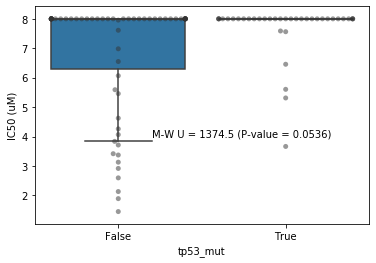

In [ ]:
fig, ax = plt.subplots()

sns.boxplot(x="tp53_mut", y="IC50 (uM)", data=pharm_mdm2, fliersize=0)
sns.swarmplot(x="tp53_mut", y="IC50 (uM)", data=pharm_mdm2, color=".2", alpha=0.5)
ax.text(0.2, 4, "M-W U = {} (P-value = {})".format(mwu1, np.round(pval1, 4)))

The correlation between TP53 mutations and the MDM2 inhibitor response is higher than between MDM2 mutations and MDM2 inhibitor response.



## Lethality analysis

In [ ]:
bcat_ataris = pd.read_csv(DATA / "GeneSensitivity_MDM2_ATARiS.csv")
bcat_ataris.head()

,CLEANNAME_PRIMARYSITE,SensitivityScore,CELLLINE,PRIMARY_SITE,PATHOLOGIST_ANNOTATION
0,cas1_central_nervous_system,1.323,cas1,central_nervous_system,CNS:Glioma_HighGrade
1,mdamb157_breast,1.291,mdamb157,breast,Breast:Carcinoma
2,saos2_bone,1.249,saos2,bone,Bone:Sarcoma_Osteo
3,gi1_central_nervous_system,1.193,gi1,central_nervous_system,CNS:Glioma
4,mdamb468_breast,1.121,mdamb468,breast,Breast:Carcinoma


In [ ]:
# To match the sample IDs we have previously, convert the sample names to upper case
bcat_ataris["sample_id"] = bcat_ataris.CLEANNAME_PRIMARYSITE.str.upper()

In [ ]:
bcat_ataris["TP53_mut"] = False
bcat_ataris.loc[bcat_ataris.sample_id.isin(tp53_mut_samples), "TP53_mut"] = True
bcat_ataris.head()

,CLEANNAME_PRIMARYSITE,SensitivityScore,CELLLINE,PRIMARY_SITE,PATHOLOGIST_ANNOTATION,sample_id,TP53_mut
0,cas1_central_nervous_system,1.323,cas1,central_nervous_system,CNS:Glioma_HighGrade,CAS1_CENTRAL_NERVOUS_SYSTEM,True
1,mdamb157_breast,1.291,mdamb157,breast,Breast:Carcinoma,MDAMB157_BREAST,True
2,saos2_bone,1.249,saos2,bone,Bone:Sarcoma_Osteo,SAOS2_BONE,False
3,gi1_central_nervous_system,1.193,gi1,central_nervous_system,CNS:Glioma,GI1_CENTRAL_NERVOUS_SYSTEM,True
4,mdamb468_breast,1.121,mdamb468,breast,Breast:Carcinoma,MDAMB468_BREAST,True


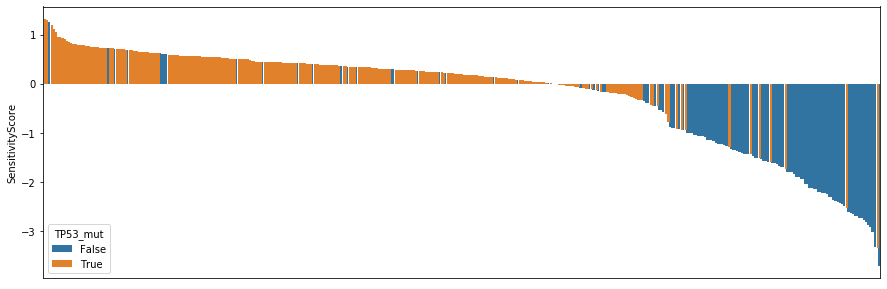

In [ ]:
# Color the cell lines based on whether it contains TP53 mutation or not.
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.barplot(x=np.arange(len(bcat_ataris)), y="SensitivityScore", hue="TP53_mut",
            data=bcat_ataris, ax=ax, ci=None)
ax.set_xticklabels([])
ax.set_xticks([])

for bar in ax.patches:
    bar.set_width(1)

Perform a Mann-Whitney U test comparing the sensitivity score distribution between the TP53 mutated cell lines vs TP53 wildtype cell lines.

In [ ]:
mwu2, pval2 = mannwhitneyu(bcat_ataris.loc[bcat_ataris.TP53_mut, "SensitivityScore"],
                         bcat_ataris.loc[~bcat_ataris.TP53_mut, "SensitivityScore"],
                         alternative="two-sided")

In [ ]:
print("P value: ", pval2)

P value:  2.3283069712299568e-31


TP53 mutation is strongly correlated with cellline sensitivity to MDM2 inhibition (more inhibition when TP53 is not mutated). The P value is much lower, which is statistically significant (way less than 0.05). The P value is 2.3283069712299568e-31.

TP53 is responsible to arresting/stopping cell cycle progression. MDM2 is an E3 ubiquitin ligase that is specific to p53 protein (encoded by TP53 gene), which means that MDM2 degrades/blocks p53. TP53 mutation makes p53 protein resistant/not sensitive to MDM2 degradation/inhibition. Thus, the cell line sensitivity to MDM2 inhibition is correlated with whether TP53 has mutated. 